In [5]:
import pandas as pd

In [6]:
import random
import numpy as np

# set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [7]:
# Target id
target_id = "CHEMBL2760"

In [8]:
from loader.load_chembl import parse_activities
# Load the data
target_raw = parse_activities(target_id=target_id)

In [10]:
target_raw.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,NaN,NaN,188231,[],CHEMBL644937,Inhibitory activity against Acid sphingomyelinase,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Sphingomyelin phosphodiesterase,9606,NaN,NaN,IC50,ug ml-1,UO_0000274,NaN,5.25
1,NaN,NaN,194117,[],CHEMBL644937,Inhibitory activity against Acid sphingomyelinase,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Sphingomyelin phosphodiesterase,9606,NaN,NaN,IC50,ug ml-1,UO_0000274,NaN,24.00
2,NaN,NaN,206131,[],CHEMBL644937,Inhibitory activity against Acid sphingomyelinase,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Sphingomyelin phosphodiesterase,9606,NaN,NaN,IC50,ug ml-1,UO_0000274,NaN,5.30
3,NaN,NaN,206133,[],CHEMBL644937,Inhibitory activity against Acid sphingomyelinase,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Sphingomyelin phosphodiesterase,9606,NaN,NaN,IC50,ug ml-1,UO_0000274,NaN,5.15
4,NaN,NaN,210721,[],CHEMBL644937,Inhibitory activity against Acid sphingomyelinase,B,NaN,NaN,BAO_0000190,...,Homo sapiens,Sphingomyelin phosphodiesterase,9606,NaN,NaN,IC50,ug ml-1,UO_0000274,NaN,34.50


In [11]:
from loader.clean_chembl import clean_data
# Clean the data
target_clean = clean_data(target_id=target_id, rewrite=False)

In [12]:
target_clean.head()

,canonical_smiles,standard_value
molecule_chembl_id,,
CHEMBL323197,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1C...,14100.0
CHEMBL4167681,CCCCCCCCCCOc1cc(C(=O)NO)ccc1OC,890.0
CHEMBL320658,COc1c(O)cc(O)c(C(=O)c2c(O)cc(O)cc2O)c1CC=C(C)C,14700.0
CHEMBL109045,COc1cc(C(=O)c2c(O)cc(O)c(CC=C(C)C)c2O)c(O)cc1O,66000.0
CHEMBL4464068,CCCCCCCCCCOc1cc(C(=O)NO)on1,360.0


In [13]:
from predictor.descriptor_computer import get_desc_dataset

rdkit_desc = get_desc_dataset(target_id, "rdkit")
rdkit_desc.head()

,smiles,standard_value,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL323197,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1C...,14100.0,13.480485,13.480485,0.010510,-0.446615,0.400171,10.966667,410.466,384.258,...,0,0,0,0,0,0,0,0,0,0
CHEMBL4167681,CCCCCCCCCCOc1cc(C(=O)NO)ccc1OC,890.0,11.430997,11.430997,0.332615,-0.565202,0.341103,10.391304,323.433,294.201,...,0,0,0,0,0,0,0,0,7,0
CHEMBL320658,COc1c(O)cc(O)c(C(=O)c2c(O)cc(O)cc2O)c1CC=C(C)C,14700.0,12.945543,12.945543,0.001304,-0.881522,0.409566,10.423077,360.362,340.202,...,0,0,0,0,0,0,0,0,0,0
CHEMBL109045,COc1cc(C(=O)c2c(O)cc(O)c(CC=C(C)C)c2O)c(O)cc1O,66000.0,12.775670,12.775670,0.061414,-0.894213,0.409566,10.423077,360.362,340.202,...,0,0,0,0,0,0,0,0,0,0
CHEMBL4464068,CCCCCCCCCCOc1cc(C(=O)NO)on1,360.0,10.999545,10.999545,0.070904,-0.736640,0.369750,10.500000,284.356,260.164,...,0,0,0,0,0,0,0,0,7,0


In [14]:
from predictor.descriptor_computer import get_desc_dataset

mordred_desc = get_desc_dataset(target_id, "mordred")
mordred_desc.head()

D:\python_projects\alzheimer-generative-design\venv\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)

KeyboardInterrupt



In [14]:
from predictor.fingerprint_computer import get_fp_dataset
from rdkit.Chem import rdFingerprintGenerator

fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
morgan_desc = get_fp_dataset(target_id, "morgan", fp_gen)
morgan_desc.head()

,smiles,standard_value,0,1,2,3,4,5,6,7,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL323197,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1C...,14100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL4167681,CCCCCCCCCCOc1cc(C(=O)NO)ccc1OC,890.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL320658,COc1c(O)cc(O)c(C(=O)c2c(O)cc(O)cc2O)c1CC=C(C)C,14700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL109045,COc1cc(C(=O)c2c(O)cc(O)c(CC=C(C)C)c2O)c(O)cc1O,66000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL4464068,CCCCCCCCCCOc1cc(C(=O)NO)on1,360.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Predicting with rdkit descriptors

In [15]:
x_rdkit_desc = rdkit_desc.drop(columns=["smiles", "standard_value"])

In [26]:
x_rdkit_desc.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL323197,13.480485,13.480485,0.010510,-0.446615,0.400171,10.966667,410.466,384.258,410.172939,158,...,0,0,0,0,0,0,0,0,0,0
CHEMBL4167681,11.430997,11.430997,0.332615,-0.565202,0.341103,10.391304,323.433,294.201,323.209658,130,...,0,0,0,0,0,0,0,0,7,0
CHEMBL320658,12.945543,12.945543,0.001304,-0.881522,0.409566,10.423077,360.362,340.202,360.120903,138,...,0,0,0,0,0,0,0,0,0,0
CHEMBL109045,12.775670,12.775670,0.061414,-0.894213,0.409566,10.423077,360.362,340.202,360.120903,138,...,0,0,0,0,0,0,0,0,0,0
CHEMBL4464068,10.999545,10.999545,0.070904,-0.736640,0.369750,10.500000,284.356,260.164,284.173607,114,...,0,0,0,0,0,0,0,0,7,0


In [17]:
import numpy as np

y10 = -np.log10(target_clean["standard_value"])

In [22]:
from sklearn.model_selection import KFold

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
scoring = ['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']
results_path = 'results.csv'

In [24]:
x_rdkit_desc.drop("numpy", axis=1, inplace=True)

Cross-validation mean scores:
  r2, mean: 0.4716, std: 0.1230
  neg_mean_absolute_error, mean: -0.4747, std: 0.0822
  neg_root_mean_squared_error, mean: -0.5985, std: 0.0768


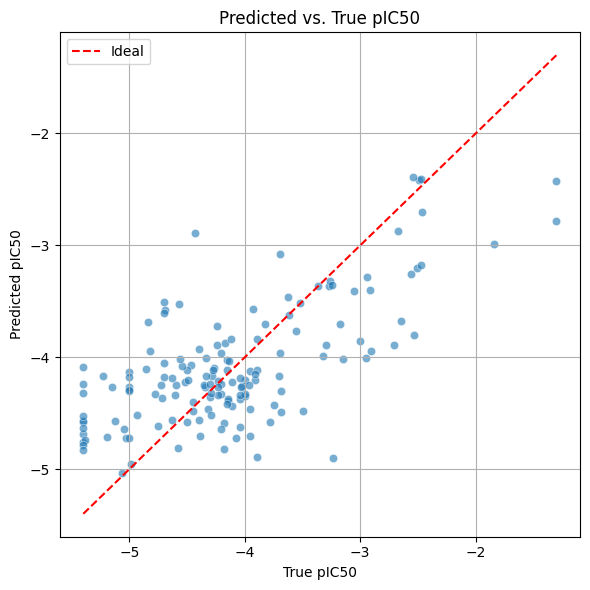

Created new results file at results.csv


In [25]:
from sklearn.preprocessing import StandardScaler
from predictor.pipeline import run_pipeline
from sklearn.ensemble import RandomForestRegressor

# baseline: RFRegressor
pipeline = run_pipeline(
    X=x_rdkit_desc,
    y=y10.squeeze(),
    cv=cv,
    model=RandomForestRegressor(n_estimators=100, random_state=SEED),
    scaler=StandardScaler(),
    scoring=scoring,
    results_path=results_path,
)